In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import date
from datetime import datetime
import scipy.stats

# Lectura de datos de COVID-19

In [2]:
# Lectura de datos
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFileDUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv' #Muertes en Estados unidos
DataFileCUS='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv' #Casos confirmados en estados unidos

cvaDUS = pd.read_csv('{}{}'.format(DataSource,DataFileDUS))
cvaCUS = pd.read_csv('{}{}'.format(DataSource,DataFileCUS))

In [3]:
# Obtencion de fecha del día de ayer para iniciar análisis con datos del último día
d = date.today()
AYER = str(d.month)+'/'+str(d.day-1)+'/'+str(d.year)[-2:]
AYER

'5/16/20'

In [4]:
# Datos provistos por CSSE de la universidad de Johns Hopkins
print('Casos hasta ayer en USA:',cvaCUS[AYER].sum(),'\nMuertes hasta ayer en USA:',cvaDUS[AYER].sum())

Casos hasta ayer en USA: 1467820 
Muertes hasta ayer en USA: 88754


# Limpieza de datos de COVID-19

In [5]:
# Limpieza de datos para obtenes solo casos dentro de estados federales 
COVCases = pd.DataFrame(cvaCUS.dropna().set_index(['Province_State','Admin2','FIPS'])[AYER])
COVCases.columns = ['CASOS']

COVDeaths = pd.DataFrame(cvaDUS.dropna().set_index(['Province_State','Admin2','FIPS'])[AYER])
COVDeaths.columns = ['MUERTES']

# Eliminar datos que categorizados como 'Unassigned'
COV = pd.merge(COVCases, COVDeaths, how = 'inner', left_index=True, right_index=True)
print('Casos sin asignar que se eliminaron:\n'+str(COV.xs('Unassigned', level='Admin2').sum()))
COV = COV.drop('Unassigned', level='Admin2')
COV.index.names = ['Estado', 'Condado','FIPS']
COV

Casos sin asignar que se eliminaron:
CASOS      5070
MUERTES     914
dtype: int64


CASOS  MUERTES
Estado        Condado   FIPS                   
Alabama       Autauga   1001.0     110        4
              Baldwin   1003.0     254        8
              Barbour   1005.0      79        1
              Bibb      1007.0      50        1
              Blount    1009.0      45        0
...                                ...      ...
Virginia      Out of VA 80051.0      0        0
Washington    Out of WA 80053.0      0        0
West Virginia Out of WV 80054.0      0        0
Wisconsin     Out of WI 80055.0      0        0
Wyoming       Out of WY 80056.0      0        0

[3193 rows x 2 columns]

# Cálculo de Mortalidad
$$ Mortalidad = \frac{Muertes}{Casos}  $$

In [6]:
COV['MORTALIDAD'] = COV['MUERTES']/COV['CASOS']
COV.head()
COV = COV.reset_index()
COV.head()

,Estado,Condado,FIPS,CASOS,MUERTES,MORTALIDAD
0,Alabama,Autauga,1001.0,110,4,0.036364
1,Alabama,Baldwin,1003.0,254,8,0.031496
2,Alabama,Barbour,1005.0,79,1,0.012658
3,Alabama,Bibb,1007.0,50,1,0.020000
4,Alabama,Blount,1009.0,45,0,0.000000


# Lectura de datos de PM2.5
Fuente: EPA
#### ESTE ES EL PASO  MAS LARGO

In [7]:
Directorio = 'DatosPM2.5/'
almacenarVar = False


PM25 = pd.DataFrame()
for i in range(51):
    #Lectura para datos promedios mensuales para cada condado
    PMC = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+').csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration','DAILY_AQI_VALUE','Site ID']]
                                   .apply(lambda df : pd.Series({'FIPS':str(df['Site ID'])[:-4],'Año':int(df['Date'][-2:]),'Mes': int(df['Date'][0:2]),'Date':df.Date,'PM 2.5':df['Daily Mean PM2.5 Concentration'],'AQI':df.DAILY_AQI_VALUE}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes','Año','FIPS'])
                                   .mean())
    
    PMC19 = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+')2019.csv')
                                   .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration','DAILY_AQI_VALUE','Site ID']]
                                   .apply(lambda df : pd.Series({'FIPS':str(df['Site ID'])[:-4],'Año':int(df['Date'][-2:]),'Mes': int(df['Date'][0:2]),'Date':df.Date,'PM 2.5':df['Daily Mean PM2.5 Concentration'],'AQI':df.DAILY_AQI_VALUE}),axis = 1)
                                   .groupby(['STATE','COUNTY','Mes','Año','FIPS'])
                                   .mean())
    # Paso opcional por si se quiere almacenar en variables diferentes cada información por estado
    if almacenarVar:
        estado = str(PMC.index[0][0])
        estado = estado.split()
        if len(estado)>1:
            estado = [estado[0]+'_'+estado[1]]
        estado = estado[0]
        globals()['PM_%s'%estado]=PMC
    
    PM25 = PM25.append(PMC)
    PM25 = PM25.append(PMC19)
    
PM25 = PM25.reset_index()
PM25.FIPS = pd.to_numeric(PM25.FIPS)

# Unión de datos de COVID y PM2.5PM25Historico

In [8]:
COVyPM25 = pd.merge(COV, PM25, how='inner', left_on=['Estado','Condado','FIPS'], right_on=['STATE', 'COUNTY','FIPS']).set_index(['Estado','Condado']).drop(['STATE','COUNTY'], axis=1)

TakeNAas0 = True

if TakeNAas0:
    COVyPM25[np.isnan(COVyPM25['MORTALIDAD'])]=0 #Reemplazo valores en donde no hay ni casos ni muertes como mortalidad = 0
else:
    COVyPM25.dropna(inplace=True)

print('Cantidad de observaciones =',len(COVyPM25))
print('Cantidad de condados con observaciones =', len(COVyPM25.groupby('Condado').mean()))

print(COVyPM25.head())

R6 = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))|((COVyPM25.Mes > 9) & (COVyPM25['Año'] == 19))].reset_index().groupby(['Estado','Condado']).mean()

S = []
C = []

for i in R6.index:
    S.append(i[0])
    C.append(i[1])

R6 = R6.reset_index()

R6.to_excel('ResultadosSemestral'+str(date.today())+'.xlsx')

R3 = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))].reset_index().groupby(['Estado','Condado']).mean()

S = []
C = []

for i in R3.index:
    S.append(i[0])
    C.append(i[1])

R3 = R3.reset_index()

R3.to_excel('ResultadosTrimestral'+str(date.today())+'.xlsx')

Cantidad de observaciones = 11475
Cantidad de condados con observaciones = 611
                   FIPS  CASOS  MUERTES  MORTALIDAD  Mes  Año  PM 2.5     AQI
Estado  Condado                                                              
Alabama Baldwin  1003.0    254        8    0.031496    1   19  6.8250  28.375
        Baldwin  1003.0    254        8    0.031496    2   19  6.8375  28.500
        Baldwin  1003.0    254        8    0.031496    3   19  7.5300  31.300
        Baldwin  1003.0    254        8    0.031496    4   19  6.2750  26.250
        Baldwin  1003.0    254        8    0.031496    5   19  6.5875  27.500


# Obtención de matrices de correlación

KendalltauResult(correlation=0.12115562391230243, pvalue=1.4843052793910909e-05)
SpearmanrResult(correlation=0.18039442235247335, pvalue=1.0581420406219676e-05)
KendalltauResult(correlation=0.16722217970743322, pvalue=3.551891220055633e-09)
SpearmanrResult(correlation=0.24282554728760752, pvalue=3.782460461906968e-09)
KendalltauResult(correlation=0.16212587132344244, pvalue=2.131071940627563e-08)
SpearmanrResult(correlation=0.2440934140536665, pvalue=6.4474771331924945e-09)
KendalltauResult(correlation=0.11795111559459448, pvalue=8.99852525105647e-06)
SpearmanrResult(correlation=0.17780870184555247, pvalue=4.60550272238154e-06)
KendalltauResult(correlation=0.13483925000761757, pvalue=3.6977014053154985e-07)
SpearmanrResult(correlation=0.2019360690004737, pvalue=1.7507294344734727e-07)
KendalltauResult(correlation=0.14233894948032827, pvalue=8.159310941215914e-08)
SpearmanrResult(correlation=0.20761921731951624, pvalue=7.865457929028918e-08)


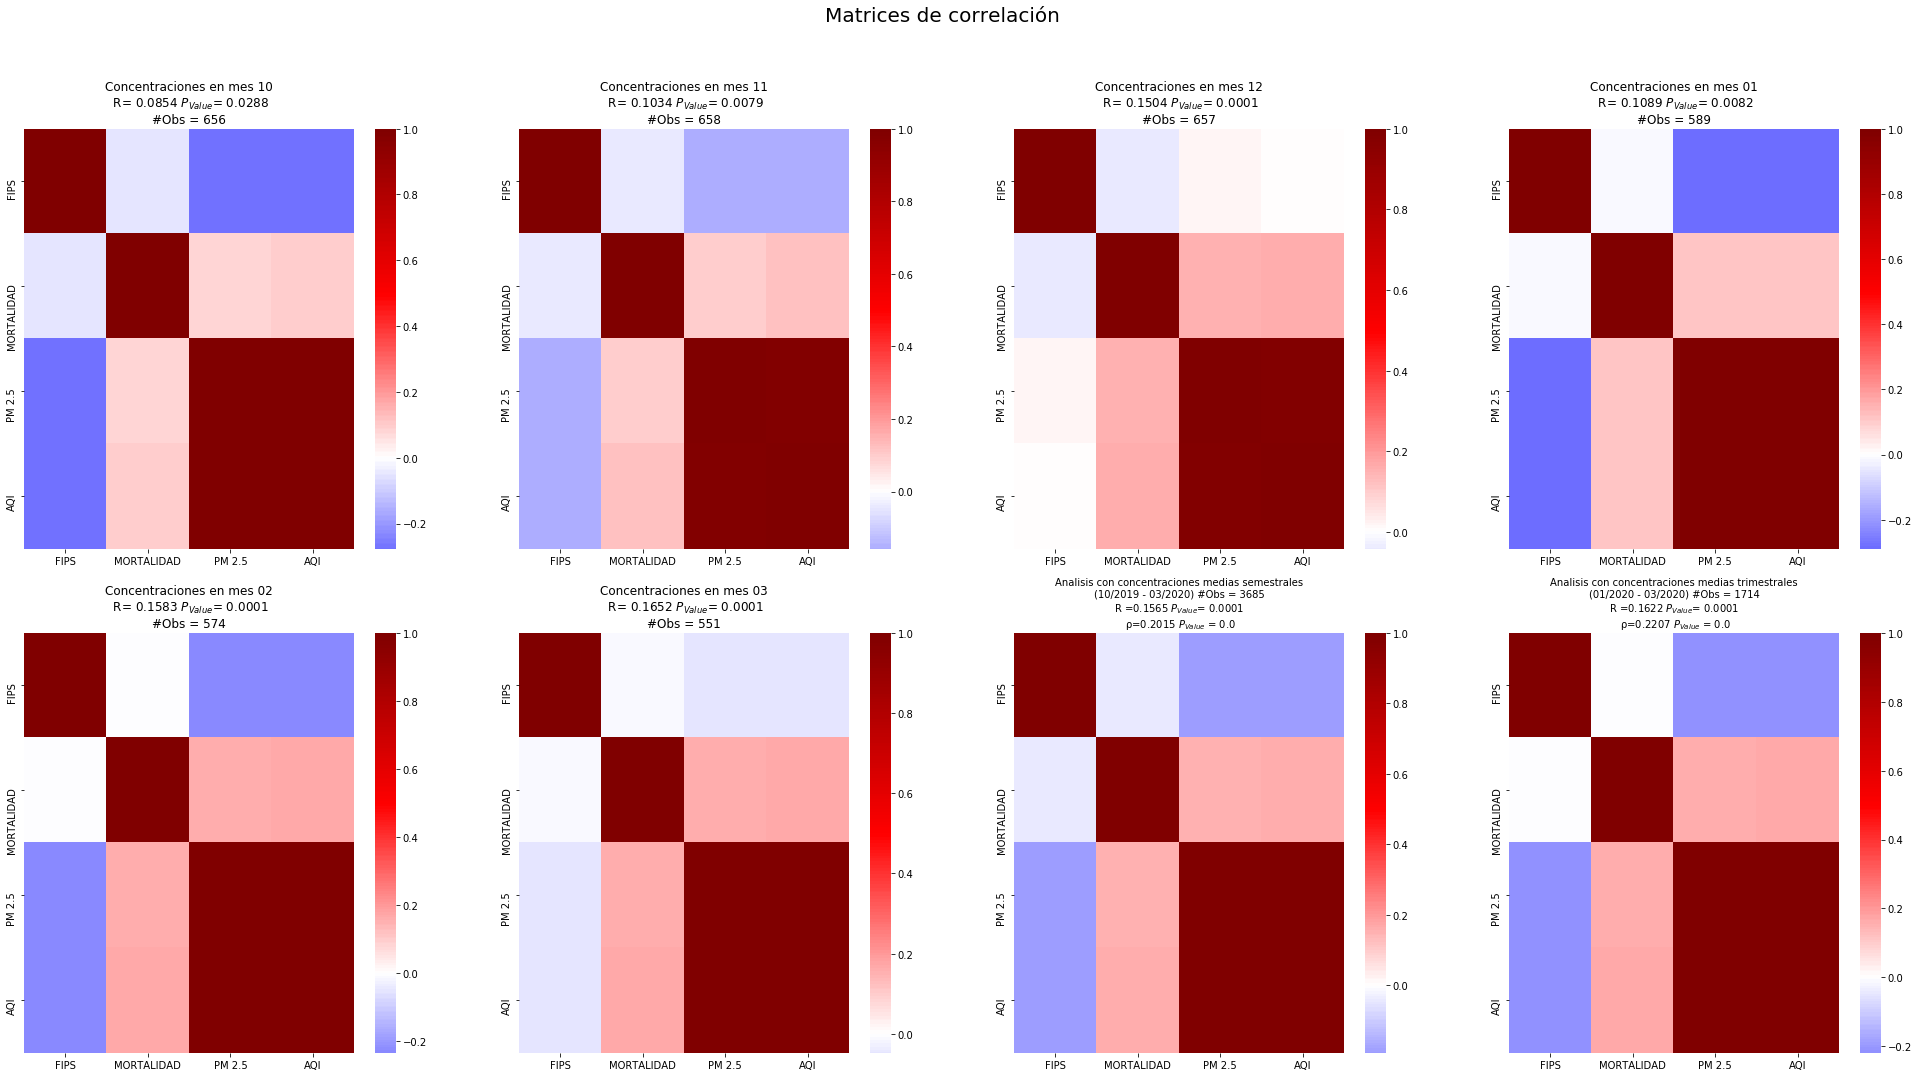

In [9]:
fig = plt.figure(figsize=(34,17))



plt.suptitle('Matrices de correlación', fontsize=20)

for i in range(3):
    plt.subplot(2,4,i+4)
    
    # Obtencion R Pearson y P-Value
    R, PVal = scipy.stats.pearsonr(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['PM 2.5']) 
    print(scipy.stats.kendalltau(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['PM 2.5']))
    print(scipy.stats.spearmanr(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]['PM 2.5']))
    
    # Matriz de correlacion mes i
    (sns.heatmap(
        COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)]
        .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
        .corr(),
        cmap = 'seismic',
        center=0))
    plt.title('Concentraciones en mes 0'+str(i+1)+'\n R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4))+'\n#Obs = '+ str(len(COVyPM25[(COVyPM25.Mes == i+1)&(COVyPM25['Año'] == 20)])))
    
for i in range(10,13):
    plt.subplot(2,4,i-9)
    
    # Obtencion R Pearson y P-Value
    R, PVal = scipy.stats.pearsonr(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['PM 2.5']) 
    print(scipy.stats.kendalltau(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['PM 2.5']))
    print(scipy.stats.spearmanr(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['MORTALIDAD'],COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]['PM 2.5']))
    
    # Matriz de correlacion mes i
    (sns.heatmap(
        COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)]
        .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
        .corr(),
        cmap = 'seismic',
        center=0))
    plt.title('Concentraciones en mes '+str(i)+'\n R= '+str(round(R,4))+' $P_{Value}$= '+str(round(PVal,4))+'\n#Obs = '+ str(len(COVyPM25[(COVyPM25.Mes == i)&(COVyPM25['Año'] == 19)])))
    
plt.subplot(247)

COVyPM6Month = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))|((COVyPM25.Mes > 9) & (COVyPM25['Año'] == 19))]

R, PVal = scipy.stats.pearsonr(COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],
                               COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 
rho, Pvalrho = scipy.stats.spearmanr(COVyPM6Month['MORTALIDAD'],COVyPM6Month['PM 2.5'])

# print(scipy.stats.spearmanr(COVyPM6Month['MORTALIDAD'],COVyPM6Month['AQI']))

(sns.heatmap(
    COVyPM6Month
    .groupby(['Estado','Condado'])
    .mean()
    .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.title('Analisis con concentraciones medias semestrales\n(10/2019 - 03/2020) #Obs = '+ str(len(COVyPM6Month)) + '\nR ='
          + str(round(R,4)) + ' $P_{Value}$= '+str(round(PVal,4))
          +'\n \u03C1='+str(round(rho,4)) + ' $P_{Value}$ = '+ str(round(Pvalrho,4))
          , fontsize=10)

plt.subplot(248)

COVyPM3Month = COVyPM25[((COVyPM25.Mes <= 3) & (COVyPM25['Año'] == 20))]

R, PVal = scipy.stats.pearsonr(COVyPM3Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],
                               COVyPM3Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 
rho, Pvalrho = scipy.stats.spearmanr(COVyPM3Month['MORTALIDAD'],COVyPM3Month['PM 2.5'])

# print(scipy.stats.spearmanr(COVyPM3Month['MORTALIDAD'],COVyPM3Month['AQI']))

(sns.heatmap(
    COVyPM3Month
    .groupby(['Estado','Condado'])
    .mean()
    .drop(['Mes','Año','CASOS','MUERTES'],axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.title('Analisis con concentraciones medias trimestrales\n(01/2020 - 03/2020) #Obs = '+ str(len(COVyPM3Month)) + '\nR ='
          + str(round(R,4)) + ' $P_{Value}$= '+str(round(PVal,4))
          +'\n \u03C1='+str(round(rho,4)) + ' $P_{Value}$ = '+ str(round(Pvalrho,4))
          ,fontsize=10)


fig.savefig('MatrizDeCorrelacionDeCadaMes'+str(date.today())+'.png', dpi=100)

                   FIPS  CASOS  MUERTES  MORTALIDAD    PM 2.5        AQI
Estado  Condado                                                         
Alabama Baldwin  1003.0  254.0      8.0    0.031496  6.820278  28.188889
        Clay     1027.0   27.0      2.0    0.074074  6.198333  25.616667
        DeKalb   1049.0  192.0      2.0    0.010417  6.478056  27.138889
        Etowah   1055.0  202.0     10.0    0.049505  8.142130  32.487037
        Houston  1069.0  132.0      4.0    0.030303  7.260833  30.041667


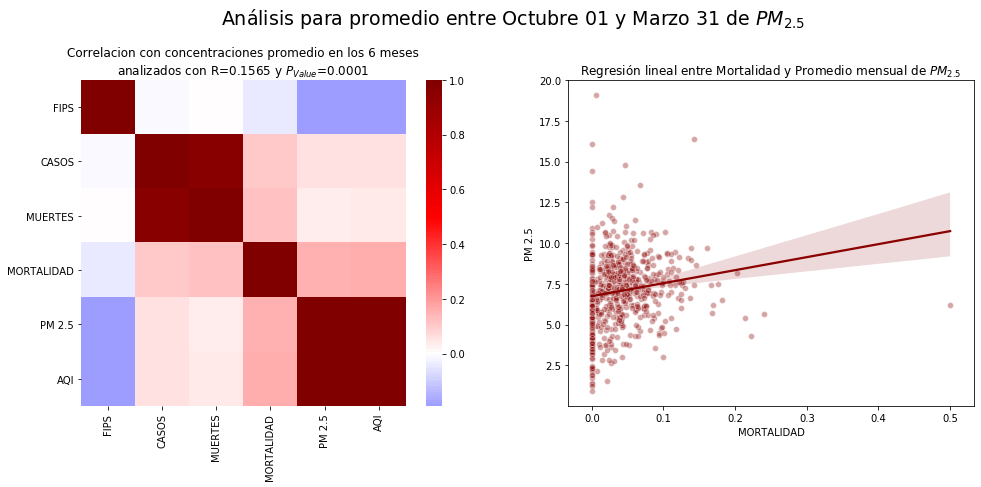

In [10]:
# Matriz de correlacion para promedio de los 6 meses (OCTUBRE NOVIEMBRE DICIEMBRE ENERO FEBRERO Y MARZO) Eliminando casos con mortalidad >= 1

fig = plt.figure(figsize=(16,6))
plt.suptitle('Análisis para promedio entre Octubre 01 y Marzo 31 de $PM_{2.5}$',y=1.05, fontsize=19)

R, PVal = scipy.stats.pearsonr(COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
                               ,COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 

plt.subplot(121)
plt.title('Correlacion con concentraciones promedio en los 6 meses\nanalizados con R='+str(round(R,4))+' y $P_{Value}$=' + str(round(PVal,4)))

(sns.heatmap(COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.subplot(122)
plt.title('Regresión lineal entre Mortalidad y Promedio mensual de $PM_{2.5}$')
sns.regplot(COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
            ,COVyPM6Month[COVyPM6Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']
            ,color='darkred',scatter_kws=dict(alpha=0.35,edgecolor='white')
            ,ci=90)


print(COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1).head())

fig.savefig('Matriz de correlación y regresion lineal SEMESTRAL '+str(date.today())+'.png',dpi=200)

663
                   FIPS  CASOS  MUERTES  MORTALIDAD    PM 2.5        AQI
Estado  Condado                                                         
Alabama Baldwin  1003.0  254.0      8.0    0.031496  6.820278  28.188889
        Clay     1027.0   27.0      2.0    0.074074  6.198333  25.616667
        DeKalb   1049.0  192.0      2.0    0.010417  6.478056  27.138889
        Etowah   1055.0  202.0     10.0    0.049505  8.142130  32.487037
        Houston  1069.0  132.0      4.0    0.030303  7.260833  30.041667


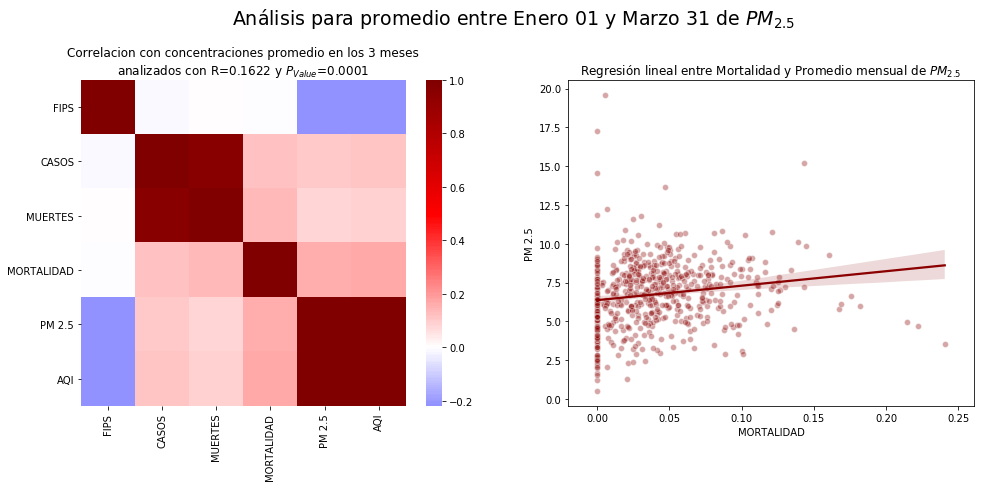

In [11]:
# Matriz de correlacion para promedio de los 3 meses (ENERO FEBRERO Y MARZO) Eliminando casos con mortalidad >= 1

fig = plt.figure(figsize=(16,6))
plt.suptitle('Análisis para promedio entre Enero 01 y Marzo 31 de $PM_{2.5}$',y=1.05, fontsize=19)

R, PVal = scipy.stats.pearsonr(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
                               ,COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']) 

plt.subplot(121)
plt.title('Correlacion con concentraciones promedio en los 3 meses\nanalizados con R='+str(round(R,4))+' y $P_{Value}$=' + str(round(PVal,4)))

(sns.heatmap(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)
    .corr(),
    cmap = 'seismic',
    center=0))

plt.subplot(122)
plt.title('Regresión lineal entre Mortalidad y Promedio mensual de $PM_{2.5}$')
sns.regplot(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']
            ,COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5']
            ,color='darkred',scatter_kws=dict(alpha=0.35,edgecolor='white')
            ,ci=90)

print(len(COVyPM6Month.groupby(['Estado','Condado']).mean()))
print(COVyPM6Month.groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1).head())

fig.savefig('Matriz de correlación y regresion lineal TRIMESTRAL '+str(date.today())+'.png',dpi=200)


# **Correlación espacio-temporal**
#### Hipótesis: La Mortalidad en cada condado en un día $y$ es mayor si la concentración de PM2.5 en el día $y-x$ es mayor.COVyPM6Month

In [12]:
# Intervalo de dias entre Mortalidad y COVID
DiasAntesPM = 60

## Datos diarios de $PM_{2.5}$

In [13]:
Directorio = 'DatosPM2.5/'
almacenarVar = False

PM25Dia = pd.DataFrame()
for i in range(51):
            
    #Lectura para datos promedios diarios para cada condado
    PMC = (pd.read_csv(Directorio+'ad_viz_plotval_data ('+str(i+1)+').csv')
           .set_index(['STATE','COUNTY'])[['Date','Daily Mean PM2.5 Concentration']])
    
    dias = []
    for i in pd.to_datetime(PMC['Date']):
        dias.append((i-np.datetime64('2020-01-01')).days)
    
    PMC['Dias desde 01/01/2020'] = dias
    
    PM25Dia = PM25Dia.append(PMC)
    
    # Paso opcional por si se quiere almacenar en variables diferentes cada información por estado
    if almacenarVar:
        estado = str(PMC.index[0][0])
        estado = estado.split()
        if len(estado)>1:
            estado = [estado[0]+'_'+estado[1]]
        estado = estado[0]
        globals()['PM_%s'%estado]=PMC
    
    
    
PM25Dia = PM25Dia.reset_index()
PM25Dia.head()

,STATE,COUNTY,Date,Daily Mean PM2.5 Concentration,Dias desde 01/01/2020
0,Alabama,Jefferson,01/01/2020,5.4,0
1,Alabama,Jefferson,01/02/2020,5.9,1
2,Alabama,Jefferson,01/03/2020,5.5,2
3,Alabama,Jefferson,01/04/2020,5.3,3
4,Alabama,Jefferson,01/05/2020,5.4,4


## Datos Mortalidad COVID-19 Diarios

In [14]:
# Limpieza de datos para obtenes solo casos dentro de estados federales 
COVCasesD = pd.DataFrame(cvaCUS.dropna().set_index(['Province_State','Admin2']))
# COVCases.columns = ['CASOS']

COVDeathsD = pd.DataFrame(cvaDUS.dropna().set_index(['Province_State','Admin2']))
# COVDeaths.columns = ['MUERTES']

COVDeathsD = COVDeathsD.iloc[:, 10:]
COVCasesD = COVCasesD.iloc[:, 9:]

dias=[]
for i in range(len(COVDeathsD.T)):
    dias.append(str((pd.to_datetime(COVDeathsD.T.index[i]) - np.datetime64('2020-01-01')).days))
    
MortalidadPerCountyDay = COVDeathsD/COVCasesD
MortalidadPerCountyDay.columns = dias

# Eliminar datos que categorizados como 'Unassigned' y 
MortalidadPerCountyDay = MortalidadPerCountyDay.drop('Unassigned', level='Admin2')

# print('Las columnas representan los dias desde el 01-01-2020')

Estado = []
Condado = []
Dia = []
Mortalidad = []

for i in range(len(MortalidadPerCountyDay)):
    for j in range(len(MortalidadPerCountyDay.T)):
        Estado.append(MortalidadPerCountyDay.index[i][0])
        Condado.append(MortalidadPerCountyDay.index[i][1])
        Dia.append(MortalidadPerCountyDay.T.index[j])
        Mortalidad.append(MortalidadPerCountyDay.iloc[i,j])

PMStateCountyMort = pd.DataFrame()
PMStateCountyMort['Estado'] = Estado
PMStateCountyMort['Condado'] = Condado
PMStateCountyMort['Dias desde 1/1/2020'] = pd.to_numeric(Dia)
PMStateCountyMort['Mortalidad'] = pd.to_numeric(Mortalidad)
PMStateCountyMort[str(DiasAntesPM) + 'dias antes'] = PMStateCountyMort['Dias desde 1/1/2020']-DiasAntesPM

PMStateCountyMort.dropna(inplace=True)

In [15]:
PMStateCountyMort[PMStateCountyMort[str(DiasAntesPM)+'dias antes']>0]

,Estado,Condado,Dias desde 1/1/2020,Mortalidad,60dias antes
62,Alabama,Autauga,83,0.0,23
63,Alabama,Autauga,84,0.0,24
64,Alabama,Autauga,85,0.0,25
65,Alabama,Autauga,86,0.0,26
66,Alabama,Autauga,87,0.0,27
...,...,...,...,...,...
369643,Utah,Out of UT,88,0.0,28
369644,Utah,Out of UT,89,0.0,29
369645,Utah,Out of UT,90,0.0,30
369646,Utah,Out of UT,91,0.0,31


## Union datos PM dias antes y mortalidad COVID actual y calculo de correlacion

In [16]:
DataCorSpaceAndTime = (pd.merge(PM25Dia, PMStateCountyMort, how = 'inner', left_on=['STATE','COUNTY','Dias desde 01/01/2020'], right_on = ['Estado','Condado',str(DiasAntesPM)+'dias antes'])
                       .drop(['STATE','COUNTY','Date',str(DiasAntesPM)+'dias antes'], axis=1)
                       .set_index(['Estado','Condado']))

DataCorSpaceAndTime.columns =['PM2.5 '+str(DiasAntesPM)+' dias antes','Dias desde 01/01/2020 PM 2.5','Dias desde 01/01/2020 COVID','Mortalidad']


# Elimino todos las celdas en donde 
DataCorSpaceAndTime = DataCorSpaceAndTime.replace([np.inf, -np.inf], np.nan).dropna()

# Cambio valores de PM2.5 negativos por 0
DataCorSpaceAndTime[DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes'] < 0] = 0

# Agrupo todas las mediciones de diferentes estaciones dentro de un mismo condado en una medicion promedio diario
DataCorSpaceAndTime = DataCorSpaceAndTime.groupby([DataCorSpaceAndTime.index,'Dias desde 01/01/2020 COVID']).mean()

# Calculo de valores de asociacion estadistica
R, Pvalue = scipy.stats.pearsonr(DataCorSpaceAndTime.Mortalidad, DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes'])
print(scipy.stats.kendalltau(DataCorSpaceAndTime.Mortalidad, DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes']))
print(scipy.stats.spearmanr(DataCorSpaceAndTime.Mortalidad, DataCorSpaceAndTime['PM2.5 '+str(DiasAntesPM)+' dias antes']))
print('Análisis con datos de PM2.5 medidos '+str(DiasAntesPM)+' dias antes\nDatos:',str(len(DataCorSpaceAndTime)),'\nR:',R,'\nP_Value:',Pvalue)

KendalltauResult(correlation=0.06634325801156686, pvalue=8.257898008830332e-64)
SpearmanrResult(correlation=0.09431445552337202, pvalue=2.589177978896443e-64)
Análisis con datos de PM2.5 medidos 60 dias antes
Datos: 32091 
R: 0.016029566222041054 
P_Value: 0.004083958352244751


# NO se evidencia una asociacion clara espacio-temporal con datos diarios

# Ensayos GLM con $Statsmodels$

In [17]:
import statsmodels.api as sm
import statsmodels as SM

In [18]:
GLMres = sm.GLM(np.array(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD']),
      np.array([COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5'],COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['AQI']]).T
      , family = sm.families.NegativeBinomial()).fit()

GLMres.params

array([ 1.81222529, -0.56205257])

In [19]:
GLMres = sm.GLM(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],
      COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5'],
      family = sm.families.NegativeBinomial()).fit()

GLMres.params

PM 2.5   -0.480817
dtype: float64

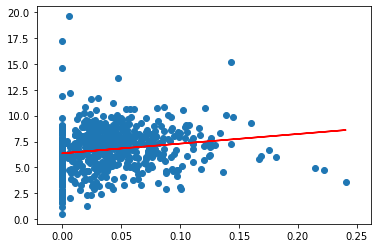

In [20]:
from scipy.optimize import curve_fit

def reg(x,m,b):
    return m*x+b

aj, cov = curve_fit(reg,COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5'])

    
plt.scatter(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'], COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['PM 2.5'])
plt.plot(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],reg(COVyPM3Month[COVyPM3Month.MORTALIDAD<1].groupby(['Estado','Condado']).mean().drop(['Mes','Año'], axis=1)['MORTALIDAD'],*aj),c='r')

# Análisis con PM2.5 histórico
#### De acuerdo a estudio de: Xiao Wu MS, Rachel C. Nethery PhD, M. Benjamin Sabath MA, Danielle Braun PhD, Francesca Dominici PhD

In [21]:
PM = pd.read_csv('https://raw.githubusercontent.com/wxwx1993/PM_COVID/master/Data/county_pm25.csv').sort_values('fips')
PM.head()

,fips,year,pm25
14744,1001.0,2007,13.914079
14739,1001.0,2002,12.842160
14740,1001.0,2003,13.939778
14741,1001.0,2004,13.180523
14742,1001.0,2005,13.999915


In [22]:
FIPS = pd.read_csv('county_fips_master.csv', encoding = 'ISO-8859-1').iloc[:,:2]
FIPS.head()

,fips,county_name
0,1001,Autauga County
1,1003,Baldwin County
2,1005,Barbour County
3,1007,Bibb County
4,1009,Blount County


In [23]:
DF = pd.merge(FIPS, PM, left_on = 'fips', right_on = 'fips')
DF

,fips,county_name,year,pm25
0,1001,Autauga County,2007,13.914079
1,1001,Autauga County,2002,12.842160
2,1001,Autauga County,2003,13.939778
3,1001,Autauga County,2004,13.180523
4,1001,Autauga County,2005,13.999915
...,...,...,...,...
52639,56045,Weston County,2002,3.423008
52640,56045,Weston County,2000,4.467315
52641,56045,Weston County,2015,3.207855
52642,56045,Weston County,2001,4.315134


In [24]:
PM25perCountyHistoric = DF.apply(lambda df : pd.Series({'FIPS':df['fips'],'Condado' : df['county_name'][:-7],'PM25' : df['pm25']}), axis = 1).groupby(['FIPS','Condado']).mean()

In [25]:
PM25Historico = PM25perCountyHistoric.reset_index()
PM25Historico

,FIPS,Condado,PM25
0,1001,Autauga,11.712587
1,1003,Baldwin,10.077723
2,1005,Barbour,10.981967
3,1007,Bibb,11.998715
4,1009,Blount,11.793023
...,...,...,...
3092,56037,Sweetwater,4.896375
3093,56039,Teton,3.867683
3094,56041,Uinta,5.088060
3095,56043,Washakie,5.025529


Coef. Pearson para datos históricos utilizados por estudio: 0.10438157206548773 . Con p-value de : 2.320253852124666e-08


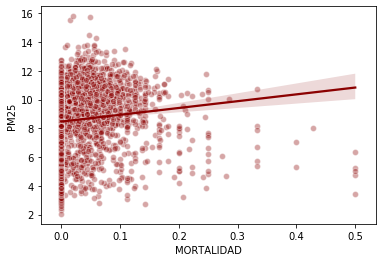

In [26]:
DFPMHistoricoMortalidad = pd.merge(COV, PM25Historico, left_on = 'FIPS', right_on = 'FIPS').drop(['CASOS','MUERTES','FIPS','Condado_y'],axis=1).set_index(['Estado','Condado_x']).dropna()
R,Pv = scipy.stats.pearsonr(DFPMHistoricoMortalidad['MORTALIDAD'][DFPMHistoricoMortalidad.MORTALIDAD<1],DFPMHistoricoMortalidad['PM25'][DFPMHistoricoMortalidad.MORTALIDAD<1])
print('Coef. Pearson para datos históricos utilizados por estudio:', R,'. Con p-value de :',Pv)
sns.regplot(DFPMHistoricoMortalidad['MORTALIDAD'][DFPMHistoricoMortalidad.MORTALIDAD<1],DFPMHistoricoMortalidad['PM25'][DFPMHistoricoMortalidad.MORTALIDAD<1],color='darkred',scatter_kws=dict(alpha=0.35,edgecolor='white')
            ,ci=90)